In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import seaborn as sns

import bayesflow as bf
from functools import partial
from IPython.display import HTML




C:\Users\Gerald Wong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\bayesflow\trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib notebook

# Amortized Posterior Estimation for Simple Agent-Based Model
**Vicsek Model in BayesFlow** 

In this notebook, we demonstrate amortized posterior estimation for a simple agent-based model (ABM). ABM is of interest because it is inherently hierarchical, but the interaction between agents does not always lead to tractable mathematical formulation. In addition, the resulting formulation can be either vague, involving little to no equations, or extremely complex, involving a large amount of parameters and equations, making meaningful inference difficult. 

Neural surrogates have proven to be one of the promising approaches for extracting model parameters for ABM. As an example, we use BayesFlow for the posterior estimation for a simple ABM: the [Vicsek model](https://en.wikipedia.org/wiki/Vicsek_model). The model, which characterizes the dynamic of collective motion, has found numerous applications from simulating active Brownian particles, from modeling social dynamics.

The model is formulated as follows:

\begin{align}
    \theta_{j, t} &= \langle \theta_{i, t}\rangle_{|r_j - r_i| < r} + \eta_{j,t-1}, \\
    \mathbf{x}_{j,t} &= \mathbf{x}_{j,t-1} + v \mathrm{d}t
    \begin{bmatrix}
        \cos \theta_{j, t} \\
        \sin \theta_{j, t}
    \end{bmatrix},
\end{align}

where

* $\theta_{j, t}, \theta_{i, t}$ is the heading direction of agent $j$ and $i$ at a given time $t$. Here, $i$ is the neighboring agent of $j$ within a perception distance $r$;
* $\eta_{j, t-1} \sim \mathcal{U}(-\mu_j, \mu_j)$ is a rotational noise for agent $j$. In addition to uniform sampling, this noise can also be sampled from  Gaussian or von Mises distributions;
* $\mathbf{x}_{j, t}$ is the position of agent $j$ as a given time $t$; and
* $v$ is the speed of agent $j$.

In [2]:
# Constants
NUM_AGENTS = 49     # Number of agents
TIME_STEPS = 200    # Number of time steps
BOUND_SIZE = 10     # Size of the square domain

# Parameter names
PARAM_NAMES = [
    r"$\alpha_j$", 
    r"$\beta_j$", 
    r"$\rho_j$",
    r"$\mu_j$",
    r"$r_j$", 
    r"$v_j$", 
    r"$\eta$"
]

### Hyperpriors and Conditional Priors

Hyperpriors:

\begin{align}
    \alpha_j, \beta_j   &\sim \mathrm{Gamma}(2, 2), \\
    \varrho_j           &\sim \mathrm{Gamma}(2, 1), \\
    \mu_j               &\sim \mathcal{U}(0, \pi).
\end{align}

Conditional priors: 

\begin{align}
    r     &\sim \mathrm{Gamma}(\varrho_j, 1), \\
    v     &\sim \mathrm{Gamma}(\alpha_j, \beta_j), \\
    \eta_j  &\sim \mathcal{U}(-\mu_j, \mu_j).
\end{align}

$\eta_j$ is not considered a hyperprior on its own, due to the fact that each agent would theoretically have a different degree of noise magnitude (further sampled from $\mu_j$, which is the hyperprior for $\eta_j$.)

In [3]:
def prior_fun(rng=None):

    if rng is None:
        rng = np.random.default_rng()
    
    # Hyperpriors
    alpha_j = rng.gamma(2,2)
    beta_j = rng.gamma(2,2)
    rho_j = rng.gamma(2,1)
    mu_j = rng.uniform(0, np.pi)

    # Conditional priors
    r = rng.gamma(rho_j, 1)
    v = rng.gamma(alpha_j, beta_j)
    eta = rng.uniform(-mu_j, mu_j)

    return np.r_[alpha_j, beta_j, rho_j, mu_j, r, v, eta]

In [4]:
prior = bf.simulation.Prior(prior_fun=prior_fun, param_names=PARAM_NAMES)
prior(batch_size=1)

{'prior_draws': array([[ 7.79252909e+00,  1.41137490e+01,  1.53797322e+00,
          4.57794837e-01,  1.68451845e+00,  1.35510260e+02,
         -7.45867840e-02]]),
 'batchable_context': None,
 'non_batchable_context': None}

### Prior Predictive Checks

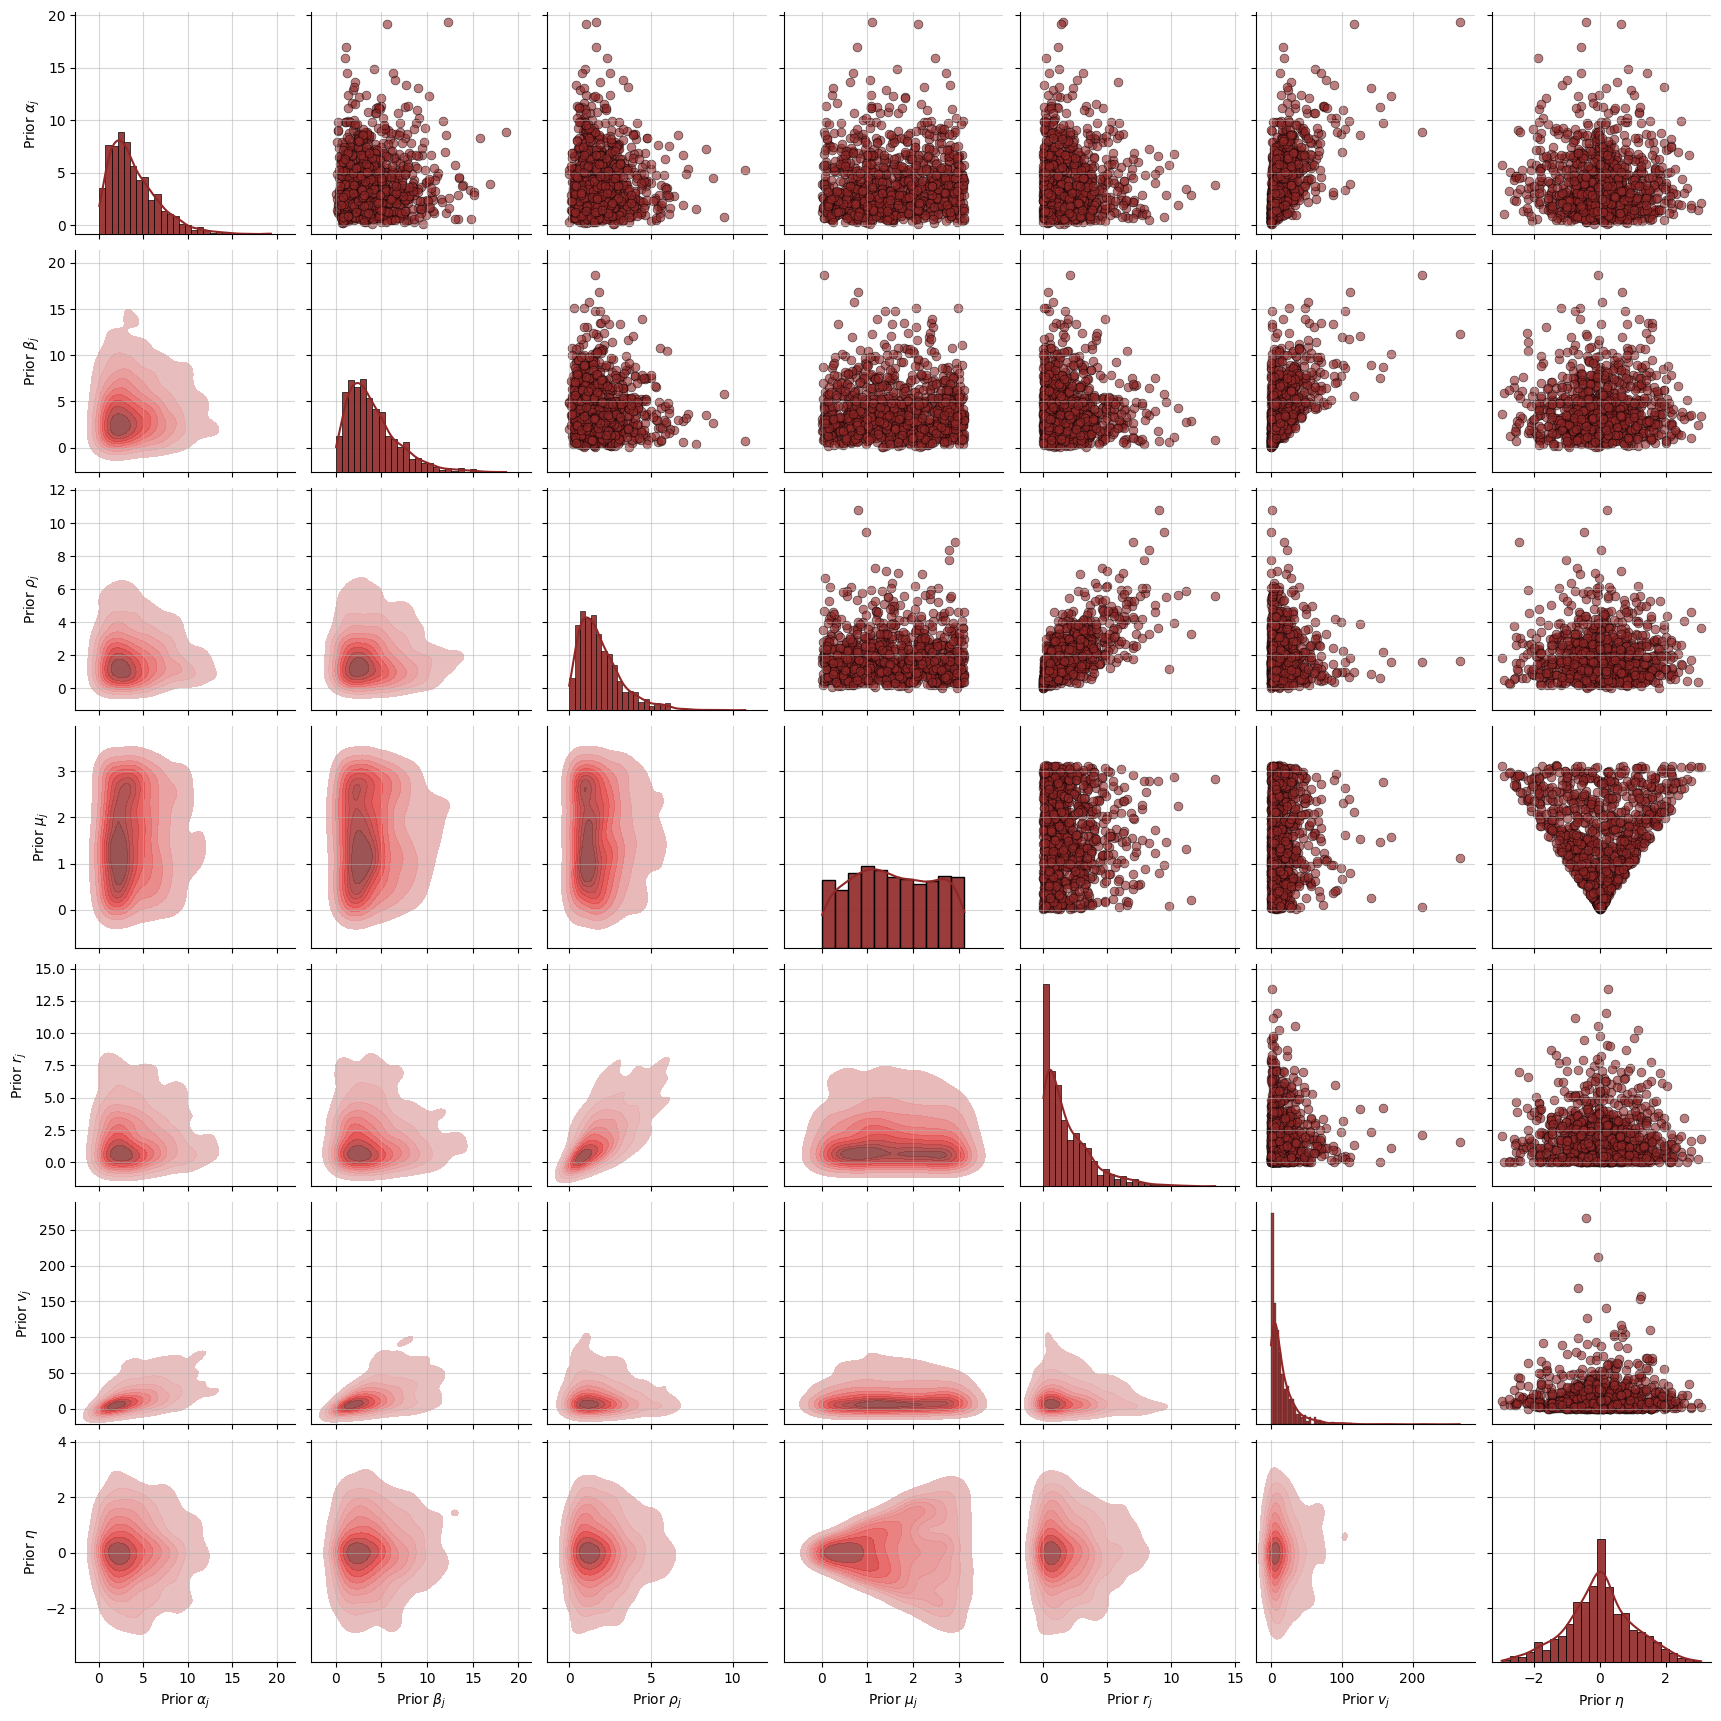

In [5]:
f = prior.plot_prior2d(n_samples=1000)

In [17]:
def initialize_agents(num_agents, boundary_size, speed, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    positions = rng.uniform(size=(num_agents, 2)) * boundary_size
    angles = rng.uniform(size=num_agents) * 2 * np.pi
    velocities = np.vstack((np.cos(angles), np.sin(angles))).T * speed

    return positions, velocities, angles

In [18]:
test_prior = prior_fun()
test_prior

array([ 2.82659911,  1.14864206,  0.79086522,  2.70997362,  0.22791646,
        5.30486061, -0.87466528])

In [19]:
positions, velocities, angles = initialize_agents(num_agents=NUM_AGENTS, boundary_size=BOUND_SIZE, speed=test_prior[-2])
angles

array([6.28236393, 0.06429379, 0.52462303, 3.54117833, 3.06738724,
       1.67318963, 3.62799647, 1.69870433, 1.9874216 , 0.90064067,
       2.75884188, 3.10695083, 5.48414163, 0.34998398, 0.91412387,
       3.82138113, 3.81725521, 4.98251746, 0.01354799, 2.17097311,
       3.4527776 , 6.14658386, 0.10489192, 4.90614966, 5.10257854,
       1.00984097, 5.72617206, 1.21817113, 4.7945826 , 4.84724445,
       4.69197694, 4.28905579, 5.2843999 , 5.4338181 , 6.16774855,
       2.85919188, 2.127362  , 0.78334278, 1.0723415 , 0.41042543,
       0.05902491, 4.2377323 , 3.7613962 , 5.44240734, 0.48482236,
       3.40397655, 2.03950947, 3.79361418, 2.74365691])

In [15]:
def update_positions(positions, velocities, L):
    positions += velocities
    positions %= L  # Periodic boundary conditions
    return positions

In [20]:
positions = update_positions(positions, velocities, BOUND_SIZE)
positions

array([[2.03847141e+00, 7.88372431e+00],
       [8.53969992e+00, 2.96537895e+00],
       [6.41414122e+00, 4.21916990e+00],
       [6.36371394e+00, 8.38524439e+00],
       [7.19664433e+00, 4.07644489e+00],
       [1.74812165e-01, 8.16195833e+00],
       [5.94628301e+00, 8.05717716e+00],
       [7.35629141e+00, 4.10770524e+00],
       [1.79451077e+00, 9.39902896e+00],
       [6.71489420e-03, 3.33820149e+00],
       [2.93394433e+00, 8.82405388e+00],
       [2.67883436e+00, 4.93805241e-01],
       [4.74798306e+00, 2.39550291e+00],
       [1.55770520e+00, 4.68762646e+00],
       [3.33761447e+00, 7.22957291e+00],
       [2.94635172e+00, 1.65205815e+00],
       [5.70093553e+00, 9.29052422e+00],
       [2.52498664e+00, 7.64302267e+00],
       [3.98809514e+00, 1.53716579e+00],
       [1.37712651e+00, 3.31227168e+00],
       [9.97124305e-01, 2.92550710e+00],
       [7.90120635e+00, 1.43496399e+00],
       [9.51335689e+00, 7.18639467e+00],
       [6.63066208e+00, 6.44077241e-01],
       [6.343323

In [21]:
new_velocities = np.zeros_like(velocities)
new_velocities

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [22]:
def update_velocities(positions, velocities, eta, r, speed, L):
    new_velocities = np.zeros_like(velocities)
    for i, pos in enumerate(positions):
        # Find neighbors within radius r
        distances = np.linalg.norm(positions - pos, axis=1)
        neighbors = np.where(distances < r)[0]

        # Compute average direction
        avg_direction = np.arctan2(np.mean(np.sin(angles[neighbors])), np.mean(np.cos(angles[neighbors])))
        new_angle = avg_direction + eta * (np.random.rand() - 0.5)
        new_velocities[i] = np.array([np.cos(new_angle), np.sin(new_angle)]).T * speed

    return new_velocities

In [23]:
velocities = update_velocities(positions=positions, velocities=velocities, eta=prior['eta'], r=prior['r'], speed=prior['v'][0], L=BOUND_SIZE)
velocities.shape

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [23]:
# Parameters
# num_agents = 100
# L = 10.0  # size of the square domain
# v = 0.03  # speed of agents
# eta = 0.1  # noise amplitude
# r = 1.0  # interaction radius
# time_steps = 300

# Initialize agents with random positions and directions
positions = np.random.rand(NUM_AGENTS, 2) * BOUND_SIZE
angles = np.random.rand(NUM_AGENTS) * 2 * np.pi
velocities = np.vstack((np.cos(angles), np.sin(angles))).T * prior['v']

def update_positions(positions, velocities, L):
    positions += velocities
    positions %= L  # Periodic boundary conditions
    return positions

def update_velocities(positions, velocities, eta, r, L):
    new_velocities = np.zeros_like(velocities)
    for i, pos in enumerate(positions):
        # Find neighbors within radius r
        distances = np.linalg.norm(positions - pos, axis=1)
        neighbors = np.where(distances < r)[0]

        # Compute average direction
        avg_direction = np.arctan2(np.mean(np.sin(angles[neighbors])), np.mean(np.cos(angles[neighbors])))
        new_angle = avg_direction + eta * (np.random.rand() - 0.5)
        new_velocities[i] = np.array([np.cos(new_angle), np.sin(new_angle)]) * prior['v']

    return new_velocities

In [51]:
def simulator_fun(params, time_steps=300, rng=None):
    """
    Simulate the Vicsek model based upon its original formulation.

    Parameters
    ----------
    params          : dict
        Array of hierarchical priors, including hyperpriors for individual agent
        and the conditional prior for all agents.
    time_steps      : int, default: 300
        The number of time steps for the simulation
    rng             : np.random.rng, default: None
        A random number generator for controlled randomness.
        If none given, then the default is used.
    
    Returns
    -------
    positions       : np.array
        An array of positions for all agents as timeseries
    velocities      : np.array
        An array of velocities for all agents as timeseries
    """

    if rng is None:
        rng = np.random.default_rng()

    # Unpack parameters
    
    

    for i in range(time_steps):
        pass    #TODO

In [28]:
# Animation
def animate(frame_num):
    global velocities, positions
    velocities = update_velocities(positions, velocities, eta, r, L)
    positions = update_positions(positions, velocities, L)

    ax.clear()
    ax.quiver(positions[:, 0], positions[:, 1], velocities[:, 0], velocities[:, 1])
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)

fig, ax = plt.subplots()
a = anim.FuncAnimation(fig, animate, frames=TIME_STEPS, interval=50)

HTML(a.to_jshtml())

<IPython.core.display.Javascript object>